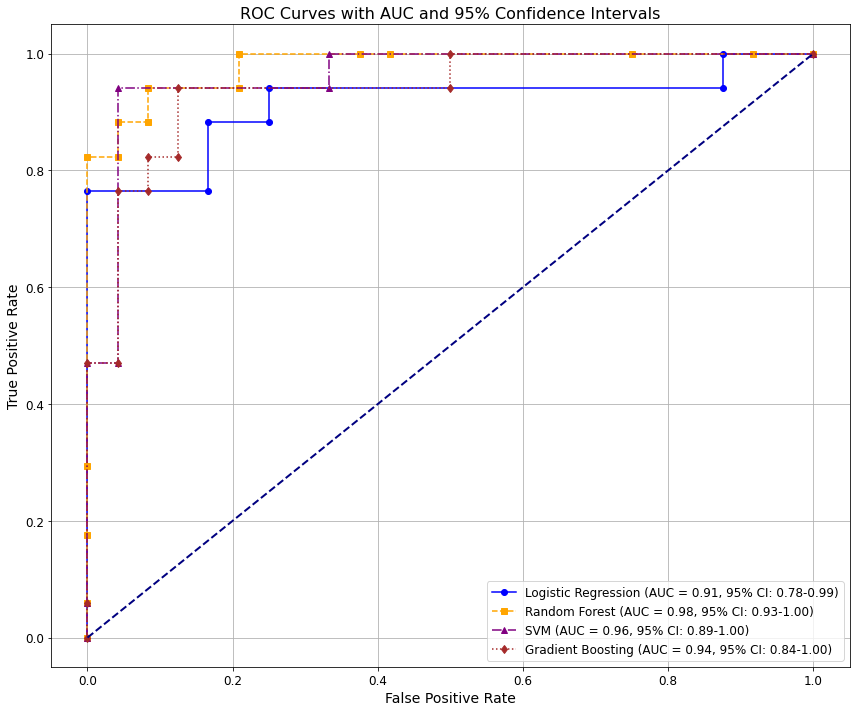

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample

# Load the dataset
file_path = 'D:\\ml\\DQ\\0904.xlsx'  
data = pd.read_excel(file_path)

# Splitting the data into features and target variable
X = data.drop('death', axis=1)
y = data['death']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the logistic regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
log_reg_probs = log_reg.predict_proba(X_test)[:, 1]

# Initialize and train the random forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_probs = rf.predict_proba(X_test)[:, 1]

# Initialize and calibrate the SVM model
svm = SVC(probability=False, random_state=42)
calibrated_svm = CalibratedClassifierCV(svm, method='sigmoid', cv=5)
calibrated_svm.fit(X_train, y_train)
svm_probs = calibrated_svm.predict_proba(X_test)[:, 1]

# Initialize and train the gradient boosting model
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
gb_probs = gb.predict_proba(X_test)[:, 1]

# Function to compute Bootstrap AUC confidence interval
def bootstrap_auc(y_true, y_scores, n_bootstraps=1000):
    y_true = np.array(y_true)
    bootstrapped_scores = []
    rng = np.random.RandomState(42)

    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_scores), len(y_scores))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_scores[indices])
        bootstrapped_scores.append(score)

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    return confidence_lower, confidence_upper

# Calculating the ROC curve and AUC for each model
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, log_reg_probs)
auc_log_reg = roc_auc_score(y_test, log_reg_probs)

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
auc_rf = roc_auc_score(y_test, rf_probs)

fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)
auc_svm = roc_auc_score(y_test, svm_probs)

fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_probs)
auc_gb = roc_auc_score(y_test, gb_probs)

# Calculating the AUC confidence intervals for each model
ci_log_reg = bootstrap_auc(y_test, log_reg_probs)
ci_rf = bootstrap_auc(y_test, rf_probs)
ci_svm = bootstrap_auc(y_test, svm_probs)
ci_gb = bootstrap_auc(y_test, gb_probs)

# Plotting the ROC curves with improved accessibility features
plt.figure(figsize=(12, 10))

# Plotting with different colors, line styles, and markers
plt.plot(fpr_log_reg, tpr_log_reg, label=f'Logistic Regression (AUC = {auc_log_reg:.2f}, 95% CI: {ci_log_reg[0]:.2f}-{ci_log_reg[1]:.2f})', linestyle='-', marker='o', color='blue')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f}, 95% CI: {ci_rf[0]:.2f}-{ci_rf[1]:.2f})', linestyle='--', marker='s', color='orange')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.2f}, 95% CI: {ci_svm[0]:.2f}-{ci_svm[1]:.2f})', linestyle='-.', marker='^', color='purple')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {auc_gb:.2f}, 95% CI: {ci_gb[0]:.2f}-{ci_gb[1]:.2f})', linestyle=':', marker='d', color='brown')

# Adding the 45-degree line for reference
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Customizing the plot for better readability
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves with AUC and 95% Confidence Intervals', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the plot
plt.savefig("roc2_curve.pdf")
plt.show()
